# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

## Blending of Machine Learning Models

In the previous notebook, we looked at an ensemble model that used voting criteria to predict the final output. What if there was a way to use a smarter and more advanced technique to produce a final output? 

There are various methods that you can use, wherein you can use the output from the base learners and train another machine learning model to intelligently give the final output. For example, if the machine learning model decides that a particular base model does not work in a trending market, it will give it less weight while predicting the final output.

In this notebook, you will use multiple machine learning models whose predicted output will be used to train a meta-model (referred to as the blender in this notebook). You will then use this blender model to predict whether the S&P500 index will go up or down the next day.

The notebook is structured as follows:
1. [Import Libraries and Data](#import)
2. [Split Data into Train and Test for Base and Meta Model](#split)
3. [Train and Predict Output for Base Models](#base)
4. [Train and Predict Output for Blender Model](#blend)
5. [Conclusion](#conclusion)

<a id='import'></a>
## Import Libraries and Data

You will use the `pandas` and `numpy` libraries for data storage and manipulation. To implement blending, you require multiple machine learning models which will act as the base learners. Thus, you will import the following ML models:

- `XGBClassifier` from the `xgboost` library
- `LogisticRegression`, `svm`, `DecisionTreeClassifier`, `ExtraTreesClassifier`, `AdaBoostClassifier` from the `sklearn` library

You will use the `train_test_split` module from `sklearn.model_selection` to split the data into train and test data.
You will also import the `accuracy_score` module from `sklearn.metrics` to compute the accuracy score of the blender model.

You will import the file `sp500_features_Jan_2009_June_2022.csv` which contains the OHLCV data of the SPDR S&P 500 ETF (ticker: SPY) from January 2009 to June 2022, along with the features that were calculated in the `Decision Tree` sections. For efficiency, the feature data is stored in the file `sp500_features_blending_model_2009_2022.csv`.

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For machine learning models
from xgboost import XGBClassifier
from sklearn.ensemble import *
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

# For splitting the data into train and test
from sklearn.model_selection import train_test_split

# For calculating accuracy scores of different ML models
from sklearn.metrics import accuracy_score

# For data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Import warnings
import warnings
warnings.filterwarnings('ignore')

# Read data file using read_csv method of pandas
spy = pd.read_csv(
    '../data_modules/sp500_features_Jan_2009_June_2022.csv', index_col=0)
X = pd.read_csv(
    '../data_modules/sp500_features_blending_model_2009_2022.csv', index_col=0)
# Print the last 5 rows of the SPY ETF values with features
spy.tail()

,Open,High,Low,Close,Volume,f_ret_1,f_ret_5,f_ret_10,f_natr,f_rsi,f_norm_upper,f_norm_lower,f_norm_middle,target
Date,,,,,,,,,,,,,,
2022-06-23,373.384588,375.555631,369.667000,374.792297,79292100,0.009803,0.001300,-0.076667,2.564619,41.207038,1.010850,0.955454,0.983152,0.031794
2022-06-24,378.103436,386.718328,378.073696,386.708405,98050300,0.031794,0.068499,-0.024101,2.528335,49.154390,1.005813,0.925544,0.965679,-0.003820
2022-06-27,387.670022,387.977340,384.091239,385.231293,66009600,-0.003820,0.062128,0.001202,2.428797,48.283114,1.015780,0.946381,0.981080,-0.020433
2022-06-28,386.857107,389.761775,377.240936,377.359894,86548900,-0.020433,0.014877,0.019451,2.539356,43.825114,1.036293,0.972660,1.004477,-0.000814
2022-06-29,377.934904,378.965893,375.149194,377.052582,65676000,-0.000814,0.015892,0.021700,2.432198,43.655642,1.033850,0.982998,1.008424,NaN


### Store Target Variable in Series

In [2]:
# Create target variable
y = np.where(spy.target > 0, 1, 0)

<a id='split'></a>
## Split Data into Train and Test for Base and Meta Model

An important part of blending is the division of the input dataset for training and testing both the base learners and blender model. Let us see how it is done in a stepwise manner.

Step 1: You will split the data into train and test datasets for the base as well as the blender model. You will first split the data in the ratio 70:30, where 70% of the feature data is used for training and named as `X_train`. The remaining 30% is used for testing and named as `X_test`.

<img src="https://d2a032ejo53cab.cloudfront.net/Course/Units/Mcq/UnitContent/eteLRWdD/dataset1.JPG">

Step 2: The train data, i.e., `X_train`, is further split in the ratio 70:30. The first 70% is used for training the base models, and is named `X_train_base`. The remaining 30% will be used by the base model for prediction and named as `X_test_base`.

<img src="https://d2a032ejo53cab.cloudfront.net/Course/Units/Mcq/UnitContent/J7Pavlcm/dataset2.JPG">

The above information is summarised below:
1. X_train_base, y_train_base: Train dataset for base model
2. X_test_base, y_test_base: Test dataset for base model

In [3]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False)

# Split the train data further for base and meta learner
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_train, y_train, test_size=0.3, shuffle=False)

### Define Function to Declare Base Learners

In [4]:
# Create a list of base models
def get_base_estimators():
    # --------------- Classifier 1: XGBoost ------------------------------------------
    xgb = XGBClassifier(max_depth=5, n_estimators=20,
                        random_state=42, eval_metric='logloss')

    # --------------- Classifier 2: Logistic Regression ------------------------------------------
    lr = LogisticRegression(random_state=42)

    # --------------- Classifier 3: SVM ------------------------------------------
    svc = svm.SVC(kernel='rbf', probability=True, random_state=42)

    # --------------- Classifier 4: Decision Tree ------------------------------------------
    dtc = DecisionTreeClassifier(
        criterion='gini', max_depth=4, min_samples_leaf=5, random_state=42)

    # --------------- Classifier 5: Extra Trees ------------------------------------------
    extra_trees = ExtraTreesClassifier(n_estimators=15, random_state=42)

    # --------------- Classifier 6: AdaBoost Classifier ------------------------------------------
    ada = AdaBoostClassifier(n_estimators=15, random_state=42)

    estimator = []
    estimator.append(('LR', lr))
    estimator.append(('SVC', svc))
    estimator.append(('XGB', xgb))
    estimator.append(('DTC', dtc))

    estimator.append(('gnb', extra_trees))
    estimator.append(('ada', ada))
    estimator.append(('rf', RandomForestClassifier(
        n_estimators=15, random_state=42)))

    return estimator

<a id='base'></a>
## Train and Predict Output for Base Models

Step 1: After defining the base machine learning models, you will train them on the features data `X_train_base` and the target variables stored in the series `y_train_base`. 

Step 2: You will predict the output on the test dataset `X_test_base`. 

Step 3: Store the predicted output in the dataframe `X_train_for_meta`, as it will be used to train the meta model, i.e., the blending model. 

Step 4: Note that the blending model is using the predicted output of the base models for its training. Thus, the blending model will require the predicted output from the base model for its test dataset as well.
Hence, you will provide the `X_test` to the base models as well, and store the predicted output in the dataframe `X_holdout_for_meta`. The dataframe `X_holdout_for_meta` will be used as input feature test data by the blending model to predict the output. 

The above information is summarised below:
1. `X_train_base`, `y_train_base`: Train dataset for base model
2. `X_test_base`, `y_test_base`: Test dataset for base model
3. `X_train_for_meta`: Predicted output of base model on `X_test_base`, and train model for blending model
4. `X_holdout_for_meta`: Predicted output of base model on X_test, and test model for blending model

<img src="https://d2a032ejo53cab.cloudfront.net/Course/Units/Mcq/UnitContent/UkTaspa2/dataset3.JPG">



In [5]:
# Create dataframe for storing train data of blending or meta learner
X_train_for_meta = pd.DataFrame(index=X_test_base.index)

# Create dataframe for storing test data of blending or meta learner
X_holdout_for_meta = pd.DataFrame(index=X_test.index)

# Call function for retrieving base models
models = get_base_estimators()

for name, model in models:
    # Fit base models on training set
    model.fit(X_train_base, y_train_base)

    # Predict on test data set for base models
    X_train_for_meta[name] = model.predict(X_test_base)

    # Predict on test dataset of meta learner
    X_holdout_for_meta[name] = model.predict(X_test)

X_train_for_meta.head()

,LR,SVC,XGB,DTC,gnb,ada,rf
Date,,,,,,,
2015-08-21,1,1,1,1,1,1,1
2015-08-24,1,1,1,1,1,1,1
2015-08-25,1,1,1,1,1,1,1
2015-08-26,1,1,0,0,0,0,0
2015-08-27,1,1,1,0,1,1,1


Based on the training, the base learners predicted whether the SPY would go up or down. As mentioned, this predicted output is stored in the `X_train_for_meta` dataframe. The trained base models also predict the output for the `X_test` dataset and store the predicted output in the `X_holdout_for_meta`. Let us now train the meta or blending model.

<a id='blend'></a>
## Train and Predict Output for Blender Model

You can use the XGBoost model as the blender model. The blender model will be trained on the `X_train_for_meta` model and will predict on the `X_holdout_for_meta` dataframe.

Test Accuracy Score 53.1%


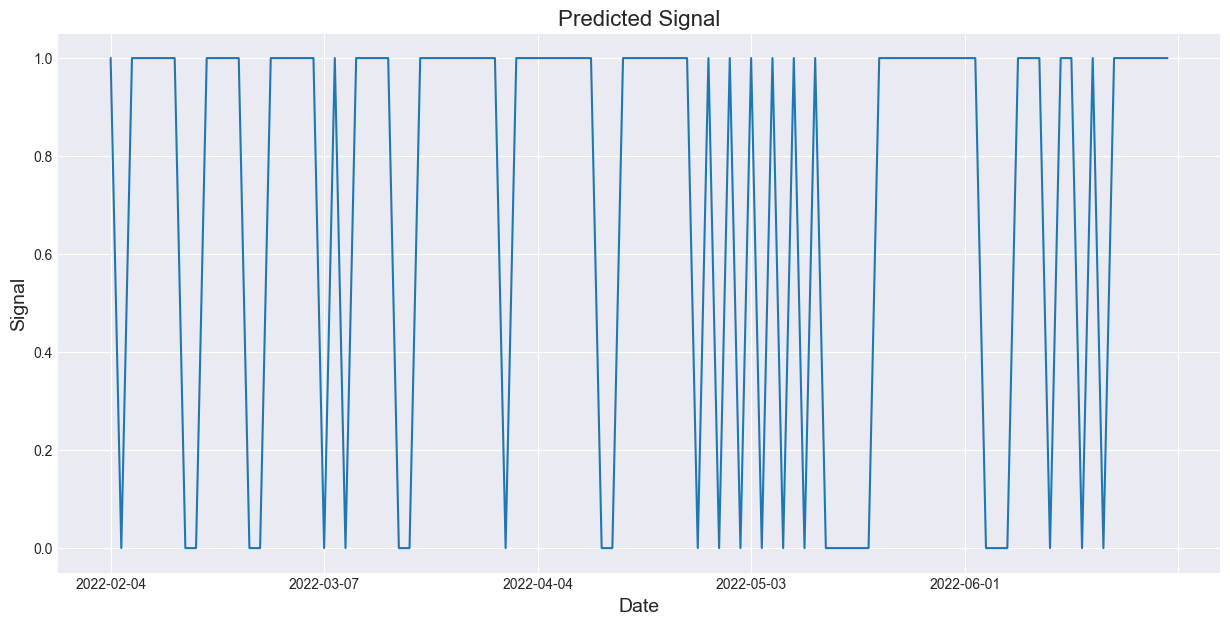

In [6]:
# Define blending model
blender = XGBClassifier(random_state=42, eval_metric='logloss')

# Fit on predictions from base models
blender.fit(X_train_for_meta, y_test_base)

# Predict on hold-out set
y_pred_test = blender.predict(X_holdout_for_meta)

# Use accuracy_score metric to predict accuracy
score = round(accuracy_score(y_test, y_pred_test)*100, 2)
print(f"Test Accuracy Score {score}%")

# Plot predicted signal
split = int(0.7*len(X))
test_data = spy[split:]
test_data['predicted_signal_blender'] = blender.predict(X_holdout_for_meta)
test_data['predicted_signal_blender'][-100:].plot(figsize=(15, 7))
plt.title('Predicted Signal', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Signal', fontsize=14)
plt.show()

You can compare the cumulative returns of the strategy with the benchmark strategy of buying and holding the SPY ETF.

Benchmark SR: 0.55
Strategy SR: 0.94


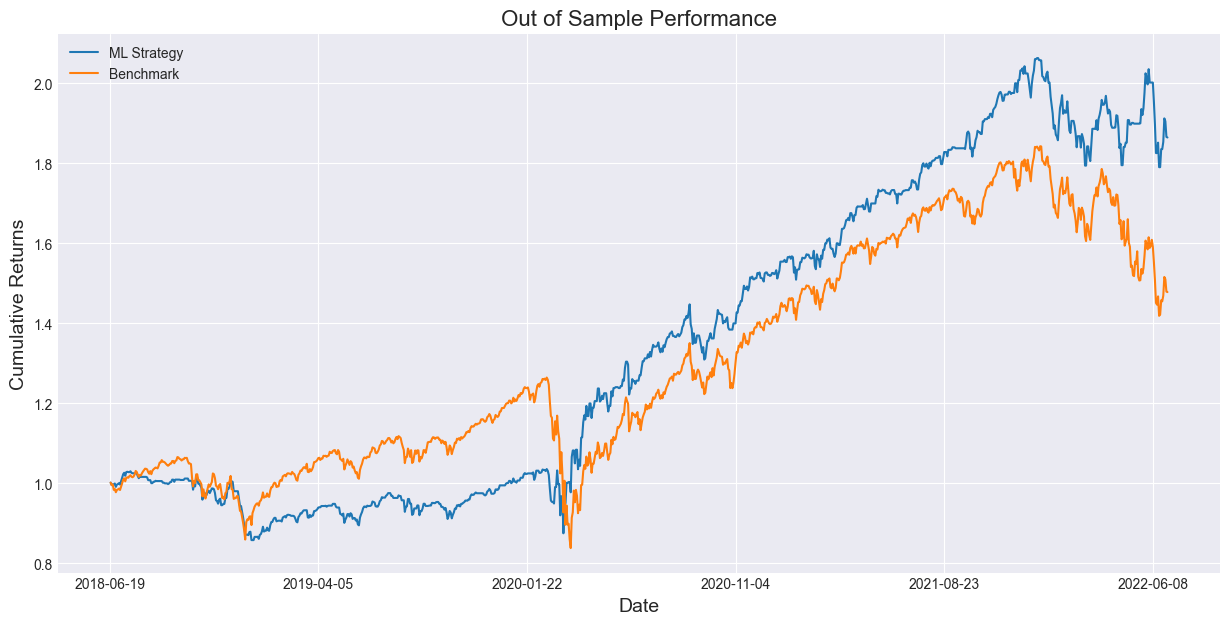

Benchmark returns: 1.48
Strategy returns: 1.86


In [7]:
# Calculate and plot the strategy returns
test_data['blender_strategy_returns'] = test_data.Close.pct_change() * test_data['predicted_signal_blender'].shift(1)

(test_data['blender_strategy_returns'] +
 1).cumprod().plot(label='ML Strategy', figsize=(15, 7))

# Plot the buy and hold strategy returns
(test_data.Close.pct_change()+1).cumprod().plot(label='Benchmark')

# Create function to calculate sharpe ratio
def get_sr(ret):
    return round(ret.mean()/ret.std()*252**0.5, 2)


# Call function to calculate sharpe ratio
print(f"Benchmark SR: {get_sr(test_data.Close.pct_change())}")
print(f"Strategy SR: {get_sr(test_data['blender_strategy_returns'])}")

# Plot title and axes labels
plt.title('Out of Sample Performance', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.legend()
plt.show()

# Print total returns
print(
    f"Benchmark returns: {round((test_data.Close.pct_change()+1).cumprod()[-1],2)}")
print(
    f"Strategy returns: {round((test_data['blender_strategy_returns']+1).cumprod()[-1],2)}")

You can see that the strategy outperformed the buy and hold strategy. Further, the sharpe ratio of the strategy is 0.94, which is higher than the benchmark.

<a id='conclusion'></a>
## Conclusion

You have used multiple machine learning models, such as the `LogisticRegression`, `svm`, `DecisionTreeClassifier`, `ExtraTreesClassifier`, `AdaBoostClassifier` to train a blending model. You also checked the performance using the cumulative returns and sharpe ratio criteria. 

You can tweak the strategy further by performing any or all of the following:
- Try different test-train split
- Try different ML models as the base learners
- Try different blender model<br><br>